# Inference using Fine-Tuned RoBERTa Model on the Complete Dataset

In this notebook, we perform inference using the previously fine-tuned RoBERTa model. The goal is to classify a large corpus of news articles (over one million entries) into ESG (Environmental, Social, Governance) or Non-ESG categories.

The main steps are:

- Load the dataset containing the news articles.
- Load the fine-tuned RoBERTa model along with its trained weights.
- Preprocess the input data by combining the title and the body of each article to generate a representative text.
- Tokenize the texts using the `roberta-base` tokenizer.
- Create a custom PyTorch Dataset to organize the tokenized data.
- Perform batch-wise inference over the entire dataset efficiently using DataLoader.
- Collect the model predictions for each article.

This inference pipeline allows us to automatically assign an ESG relevance label to all news entries, setting the foundation for further processing, analysis, and strategy development based on ESG-related information.

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaModel
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the News Dataset for Inference

We start by loading the complete news dataset where we will apply the RoBERTa-based ESG classifier.

- **Dataset size:** 1,070,261 rows and 12 columns.
- **Content:** Each row corresponds to a news article, containing fields such as `title`, `content`, `date`, `source`, `ticker`, `sector`, and others.
- **Objective:** Predict whether each news article is ESG-related (`1`) or not ESG-related (`0`).

This dataset was previously collected from multiple APIs (NewsAPI, Quantexa, FMP) to cover the period from **March 2020 to March 2025**.

In [ ]:
path = '/content/drive/MyDrive/MIAX/TFM/ROBERTA ESG O NO/noticias_totales.csv'
df_trainning = pd.read_csv(path)
df_trainning

<ipython-input-7-dc78bb11701a>:2: DtypeWarning: Columns (5,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trainning = pd.read_csv(path)


,id,Publication Date,title,content,source,sentiment_body,sentiment_body_score,company,sector,url,ticker,description
0,1.0,2024-12-09 08:41:30+00:00,Call of Duty: Black Ops 6 Review,The last year or so wasn’t the kindest to Call...,Eggplante,positive,0.98,activision,Communication,NaN,ATVI,NaN
1,2.0,2024-07-23 17:13:37+00:00,Xbox Celebrates the Release of Modern Warfare ...,"Recently, many rumors were running on the inte...",Cinelinx,positive,0.90,activision,Communication,NaN,ATVI,NaN
2,3.0,2024-07-18 14:19:34+00:00,How ToxMod's AI impacted toxicity in Call of D...,It's no secret Call of Duty has toxic players....,DNyuz,neutral,0.48,activision,Communication,NaN,ATVI,NaN
3,4.0,2024-07-18 14:04:50+00:00,How ToxMod's AI impacted toxicity in Call of D...,It's no secret Call of Duty has toxic players....,Allusanewshub,neutral,0.54,activision,Communication,NaN,ATVI,NaN
4,5.0,2024-05-27 07:03:20+00:00,"Meta, Activision Sued by Families of Uvalde Sc...",In the wake of the tragic shooting at Robb Ele...,Tech Times,neutral,0.92,activision,Communication,NaN,ATVI,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1070256,NaN,2025-03-21 16:21:09,Nike shares tumble as tariff concerns shake in...,"Shares in NIKE, Inc. (NYSE: NKE) are falling i...",Fast Company,NaN,NaN,nike,NaN,https://www.fastcompany.com/91303743/nike-shar...,NKE,NaN
1070257,NaN,2025-03-21 20:20:23,Making Sense of Early Q1 Earnings Reports,We have been seeing some of the early Q1 resul...,Zacks Investment Research,NaN,NaN,nike,NaN,https://www.zacks.com/commentary/2433762/makin...,NKE,NaN
1070258,NaN,2025-03-22 07:30:00,"Why Is Nike Stock Falling, and Should Investor...",Nike's (NKE -5.37%) sales are declining in eve...,The Motley Fool,NaN,NaN,nike,NaN,https://www.fool.com/investing/2025/03/22/why-...,NKE,NaN
1070259,NaN,2025-03-22 11:00:00,Will Nike Investors' Frustrations End Anytime ...,"If you're a Nike (NKE -5.37%) investor, it wou...",The Motley Fool,NaN,NaN,nike,NaN,https://www.fool.com/investing/2025/03/22/will...,NKE,NaN


## Loading the Pretrained RoBERTa ESG Classifier

We redefine the RoBERTa-based model architecture exactly as it was during training, ensuring full compatibility with the saved model weights.

In [ ]:
class RoBERTaClass(nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base', return_dict=True)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(768, 2)  # 2 clases: ESG y No ESG

    def forward(self, input_ids, attention_mask):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output.pooler_output)
        return self.out(pooled_output)

ruta_pesos = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/esg_model_weights.pt"
model = RoBERTaClass()
model.load_state_dict(torch.load(ruta_pesos, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [ ]:
df_trainning['title'] = df_trainning['title'].fillna('')
df_trainning['content'] = df_trainning['content'].fillna('')
df_trainning['text'] = df_trainning['title'] + ". " + df_trainning['content'].str.slice(0, 300)

In [ ]:
df_filtered = df_trainning[['text']]

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0)
        }

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
dataset = InferenceDataset(df_filtered['text'].tolist(), tokenizer, max_len=256)
dataloader = DataLoader(dataset, batch_size=64)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def infer_model(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Clasificando noticias"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions)

In [ ]:
preds = infer_model(model, dataloader, device)

Clasificando noticias: 100%|██████████| 16723/16723 [1:54:44<00:00,  2.43it/s]


In [ ]:
df_filtered['esg_pred'] = preds

<ipython-input-15-cc0d01e4f326>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['esg_pred'] = preds


In [ ]:
df_filtered['esg_pred'].value_counts()

,count
esg_pred,
0,639041
1,431220


In [ ]:
if len(preds) == len(df_trainning):
    df_trainning['esg_pred'] = preds
    print("✅ Predicciones añadidas correctamente al DataFrame original.")
else:
    print(f"Tamaños no coinciden: {len(preds)} predicciones vs {len(df_trainning)} filas.")

✅ Predicciones añadidas correctamente al DataFrame original.


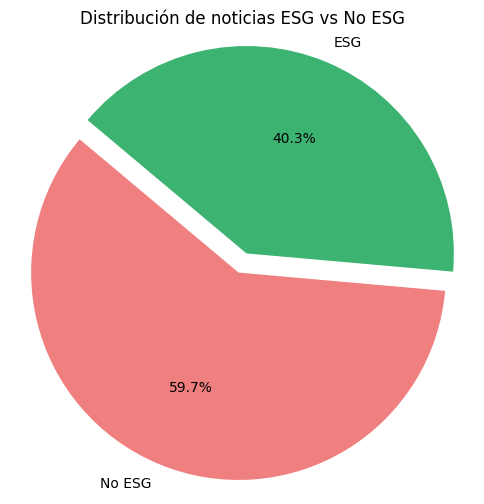

In [ ]:
counts = df_trainning['esg_pred'].value_counts()
labels = ['No ESG', 'ESG']
colors = ['lightcoral', 'mediumseagreen']

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, explode=(0.05, 0.05))
plt.title('Distribución de noticias ESG vs No ESG')
plt.axis('equal')
plt.show()

In [ ]:
df_trainning.to_csv('/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/total_news_esg_filtered.csv', index=False)

In [ ]:
print("Ejemplos predichos como ESG (1):")
display(df_trainning[df_trainning['esg_pred'] == 1].sample(5, random_state=999)[['title', 'content', 'esg_pred']])

✅ Ejemplos predichos como ESG (1):


,title,content,esg_pred
164677,Thinking about trading options or stock in App...,"NEW YORK, June 9, 2022 /PRNewswire/ -- Investo...",1
175248,How Amazon Will Be Bringing Cancelled Festival...,When Austin's annual South by Southwest festiv...,1
341956,Goldman Sachs commences latest round of layoff...,JPMorgan analyst Nick Lai…\r\nJPMorgan analyst...,1
37802,Opinion: Show support for food scrap site in C...,"As COP 28 gears up for its final week, the wor...",1
27752,Woman accused of attacking McDonald's coworker...,TribLIVE's Daily and Weekly email newsletters ...,1
